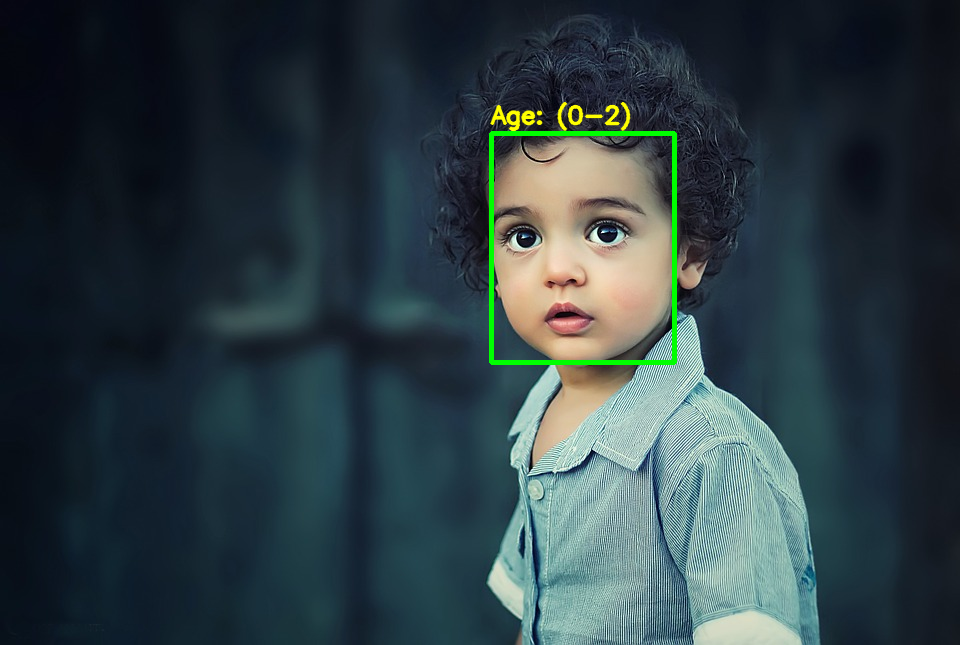

In [18]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import the Colab-specific function


# Load the pre-trained models
face_proto = "opencv_face_detector.pbtxt"
face_model = "opencv_face_detector_uint8.pb"
age_proto = "age_deploy.prototxt"
age_model = "age_net.caffemodel"

face_net = cv2.dnn.readNetFromTensorflow(face_model, face_proto)
age_net = cv2.dnn.readNetFromCaffe(age_proto, age_model)

def detect_faces(net, frame, conf_threshold=0.7):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    face_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            face_boxes.append([x1, y1, x2, y2])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height/150)), 8)
    return frame, face_boxes

def predict_age(face, net):
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    net.setInput(blob)
    age_preds = net.forward()
    age = age_list[age_preds[0].argmax()]
    return age

# Process a single image
def process_image(image_path):
    # Load the image from the specified path
    frame = cv2.imread(image_path)

    # Check if the image is loaded correctly
    if frame is None:
        print(f"Error: Image not found at {image_path}")
        return

    # Detect faces in the image
    frame, face_boxes = detect_faces(face_net, frame)

    # Process each detected face
    for (x1, y1, x2, y2) in face_boxes:
        face = frame[max(0, y1-20):min(y2+20, frame.shape[0]-1),
                     max(0, x1-20):min(x2+20, frame.shape[1]-1)]
        age = predict_age(face, age_net)
        cv2.putText(frame, f"Age: {age}", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    # Display the output image with age labels
    cv2_imshow(frame)  # Using cv2_imshow for Google Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = "kid1.jpg"  # Replace with the actual image path
process_image(image_path)
